In [13]:
import torch
import argparse
import random
import math
from torch.utils import data
from torchvision import datasets, transforms

from J_Model import PCModel
import J_optim as optim
import J_utils as utils

from PIL import Image
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle

from stimuli_data import *
from image_net_data import *

In [14]:
# ====================================================================================
#
# Global Parameters and Settings
#
# ====================================================================================
parser = argparse.ArgumentParser(description='Predictive Coding')

# dataset params
parser.add_argument('--batch-size', type=int, default=8,
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000,
                    help='input batch size for testing (default: 1000)')

# optim params
parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
parser.add_argument('--epoch', type=int, default=1, help='epochs for training')

# inference params
parser.add_argument('--infer-lr', type=float, default=0.01, help='Inference learning rate')
parser.add_argument('--infer-iter', type=int, default=50, help='Iteration for inference')
parser.add_argument('--test-iter', type=int, default=1000, help='Iteration for testing')

# convergence tolerance
parser.add_argument('--convergence-norm', type=str, default="L2", help="Norm for measuring convergence")
parser.add_argument('--convergence-tolerance', type=float, default=1e-5, help="Tolerance for measuring convergence")

# experiment params
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
parser.add_argument('--test-every', type=int, default=1, help='Test Cycle regards to Epoch ')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')

# args = parser.parse_args()
args, unknown = parser.parse_known_args()

# Gpu Setting
# use_cuda = not args.no_cuda and torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")

# Misc. Setting
# torch.manual_seed(args.seed)
torch.manual_seed(random.randint(0,1024))


In [15]:
classes = ["n11939491", "n04330267", "n04326547", "n04328186", "n04330267", "n09468604", "n09472597", "n04522168", "n02974003",
           "n03220513", "n03223299", "n03240683", "n03355925"]

torch.float32


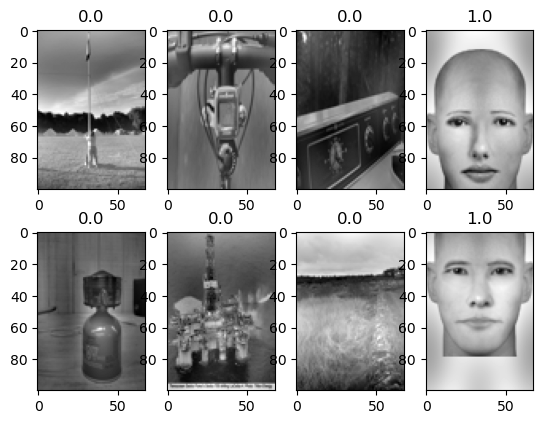

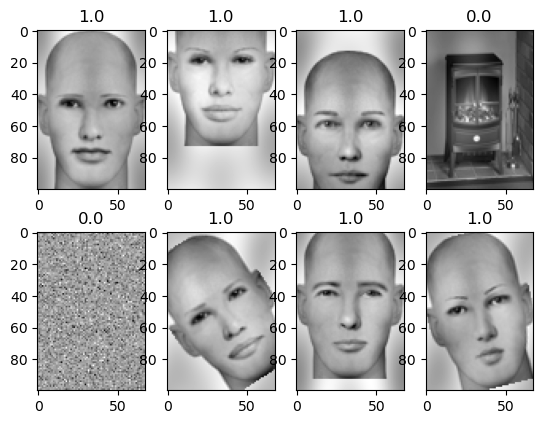

In [16]:
face_loader = get_dataloader(classes=classes, radius=(2, 3),
                            num_translations=3, num_rotations=3, num_images=123)

features, labels = next(iter(face_loader))

fig, axs = plt.subplots(2, 4)
i = 0
for ax in axs.flat:
    ax.imshow(features[i].squeeze(0), cmap="gray")
    ax.set_title(labels[i].item())
    i += 1

features, labels = next(iter(face_loader))

fig, axs = plt.subplots(2, 4)
i = 0
for ax in axs.flat:
    ax.imshow(features[i].squeeze(0), cmap="gray")
    ax.set_title(labels[i].item())
    i += 1

print(labels[0].dtype)

In [17]:
# ====================================================================================
#
# Learning / Training
#
# ====================================================================================
model = PCModel(
    nodes=[6800, 300, 100, 2],
    mu_dt=args.infer_lr,
    act_fn=utils.Tanh(),
    tol=args.convergence_tolerance,
    norm=args.convergence_norm
)

optimizer = optim.get_optim(
    model.params,
    "Adam",
    args.lr,
    batch_scale=False,
    grad_clip=50,
)


In [18]:

with torch.no_grad():
    metrics = {"acc": []}

    for epoch in range(1, args.epoch + 1):

        # Training
        print(f"Epoch {epoch} is training with ({len(face_loader)} batches)")
        for batch_id, (img_batch, label_batch) in enumerate(face_loader):
            
            img_batch = utils.to_vector(img_batch)
            img_batch = img_batch.float()
            
            label_batch = label_batch.long()
            label_batch = utils.one_hot(label_batch,n_classes=2)

            model.train_batch_supervised(img_batch, label_batch, args.infer_iter, fixed_preds=False)

            optimizer.step(
                curr_epoch=epoch,
                curr_batch=batch_id,
                n_batches=len(face_loader),
                batch_size=img_batch.size(0),
            )

        # Testing
        if epoch % args.test_every == 0:
            acc = 0
            for _, (img_batch, label_batch) in enumerate(face_loader):
                label_batch = label_batch.long()
                img_batch = img_batch.double()
                
                img_batch = utils.to_vector(img_batch)
                label_batch = utils.one_hot(label_batch,n_classes=2)

                label_preds, t = model.test_batch_supervised(img_batch, label_batch, args.test_iter, fixed_preds=False)
                acc += utils.Want_accuracy(label_preds, label_batch)
            metrics["acc"].append(acc / len(face_loader))
            print(f"Test epoch {epoch} with Accuracy: {acc / len(face_loader)}\n")

Epoch 1 is training with (126 batches)
Test epoch 1 with Accuracy: 0.8859126984126984



In [19]:
shuffle_dl = get_dataloader_shuffled(num_rotations=0, num_translations=0)
block_shuffle_dl = get_dataloader_block_shuffled(num_rotations=0, num_translations=0)

In [20]:
with torch.no_grad():
    acc = 0
    conv_times = []
    for _, (img_batch, label_batch) in enumerate(shuffle_dl):
        label_batch = label_batch.long()
        img_batch = img_batch.double()
        
        img_batch = utils.to_vector(img_batch)
        label_batch = utils.one_hot(label_batch,n_classes=2)

        label_preds, times = model.test_batch_supervised(img_batch, label_batch, args.test_iter, fixed_preds=False)
        
        conv_times += times
        acc += utils.Want_accuracy(label_preds, label_batch)
    print(f"Shuffled faces has Accuracy: {acc / len(shuffle_dl)}\n")

Shuffled faces has Accuracy: 0.8046875



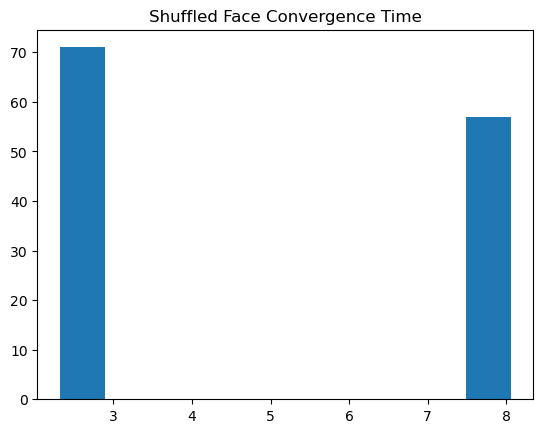

In [21]:
plt.figure()
plt.hist([t for t in conv_times if t is not None], 10)
plt.title("Shuffled Face Convergence Time")
plt.show()

In [22]:
with torch.no_grad():
    acc = 0
    for _, (img_batch, label_batch) in enumerate(block_shuffle_dl):
        label_batch = label_batch.long()
        img_batch = img_batch.double()
        
        img_batch = utils.to_vector(img_batch)
        label_batch = utils.one_hot(label_batch,n_classes=2)

        label_preds, times = model.test_batch_supervised(img_batch, label_batch, args.test_iter, fixed_preds=False)

        conv_times += times
        acc += utils.Want_accuracy(label_preds, label_batch)
    print(f"Block-shuffled faces has Accuracy: {acc / len(block_shuffle_dl)}\n")

Block-shuffled faces has Accuracy: 0.9375



In [23]:
print(conv_times)

[2.36, 7.9, 8.02, 2.37, 7.890000000000001, 8.05, 2.35, 2.33, 2.32, 7.8100000000000005, 2.34, 7.86, 2.32, 8.0, 2.34, 2.35, 2.34, 7.7700000000000005, 7.94, 2.33, 7.91, 2.35, 8.03, 2.36, 7.74, 7.86, 2.35, 2.34, 8.0, 7.8, 7.72, 7.88, 2.36, 2.34, 2.35, 2.35, 7.9, 2.45, 2.38, 7.87, 7.8100000000000005, 2.34, 2.34, 2.38, 2.35, 2.36, 2.34, 2.35, 7.84, 7.66, 8.06, 7.95, 2.36, 7.88, 2.35, 2.36, 7.88, 2.32, 7.72, 2.34, 7.72, 2.34, 7.92, 7.890000000000001, 2.37, 2.36, 7.76, 2.35, 7.87, 7.83, 2.45, 2.34, 8.02, 7.69, 2.36, 2.33, 8.02, 7.99, 7.95, 2.33, 2.35, 7.78, 2.34, 7.84, 2.36, 2.35, 7.95, 2.34, 2.35, 2.36, 7.86, 7.94, 8.01, 2.34, 2.37, 2.32, 2.34, 7.84, 7.8500000000000005, 2.34, 2.36, 2.35, 2.36, 2.34, 7.75, 7.84, 2.32, 8.040000000000001, 2.35, 2.35, 7.930000000000001, 7.97, 2.34, 2.35, 7.97, 2.35, 7.79, 2.34, 7.98, 2.41, 7.91, 2.36, 2.34, 2.33, 7.82, 2.34, 7.92, 2.33, 7.95, 2.35, 7.62, 2.35, 2.42, 2.34, 8.01, 2.34, 7.8100000000000005, 2.35, 2.36, 2.36, 2.36, 7.55, 2.34, 2.34, 2.34, 2.35, 7.79, 

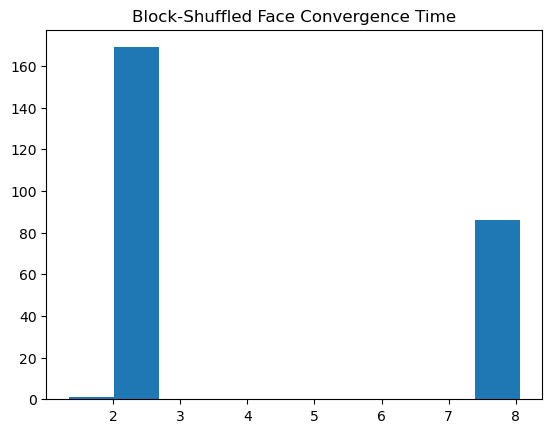

In [24]:
plt.figure()
plt.hist([t for t in conv_times if t is not None], 10)
plt.title("Block-Shuffled Face Convergence Time")
plt.show()

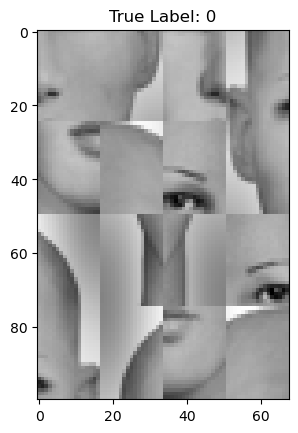

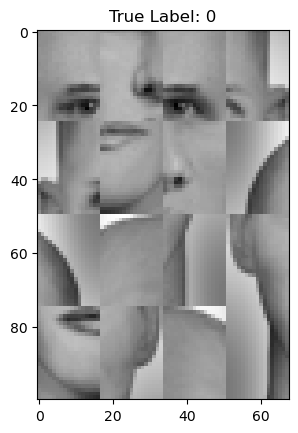

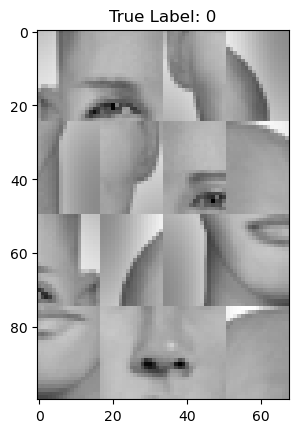

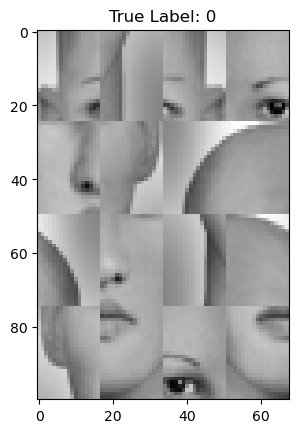

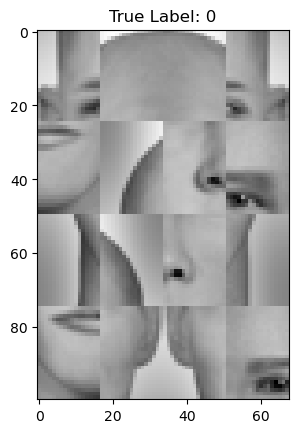

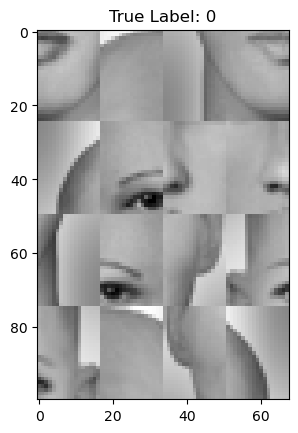

False positive rate: 0.09375


In [10]:
with torch.no_grad():
    acc = 0
    num_wrong = 0
    for _, (img_batch, label_batch) in enumerate(block_shuffle_dl):
        label_batch = label_batch.long()            
        label_batch = utils.one_hot(label_batch,n_classes=2)

        img_batch = img_batch.double()
        img_batch2 = utils.to_vector(img_batch)

        for i in range(len(label_batch)):
            label = label_batch[i]
            
            label_predictions = model.test_batch_supervised(img_batch2[i])

            if torch.argmax(label_predictions) != torch.argmax(label):
                num_wrong += 1
                plt.figure()
                plt.imshow(img_batch[i].squeeze(), cmap="gray")
                plt.title(f"True Label: {torch.argmax(label).item()}")
                plt.show()

sample_size = len(block_shuffle_dl.dataset)
shuffled_sample_size = sample_size // 2 #half are shuffled, half are not
print(f"False positive rate: {num_wrong/shuffled_sample_size}")

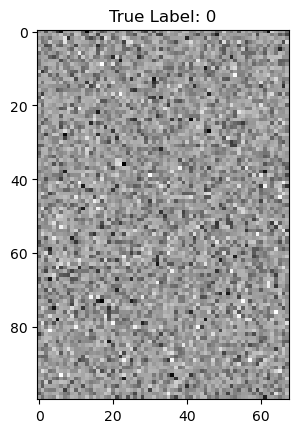

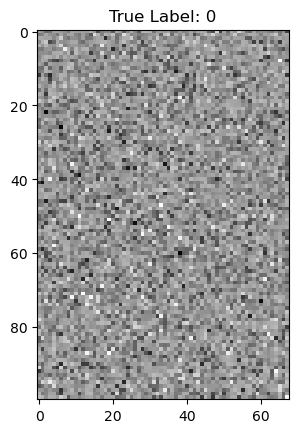

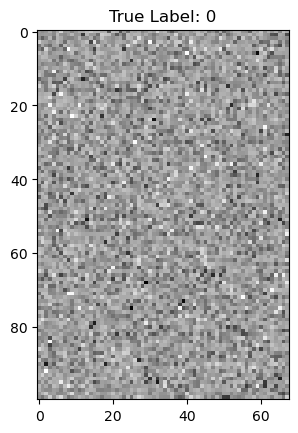

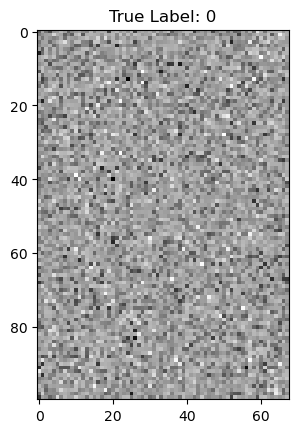

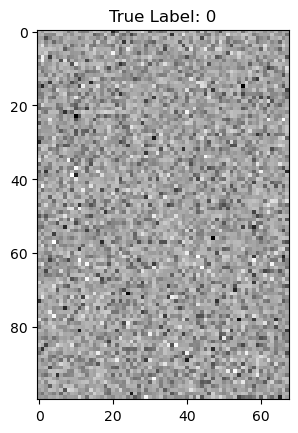

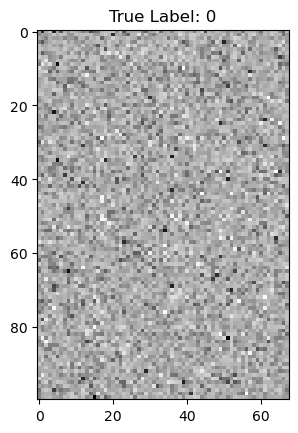

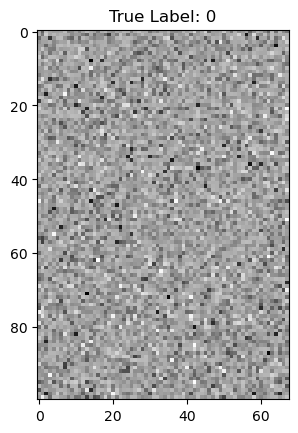

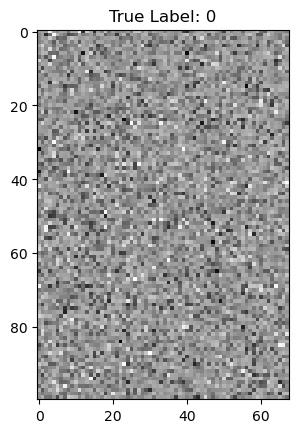

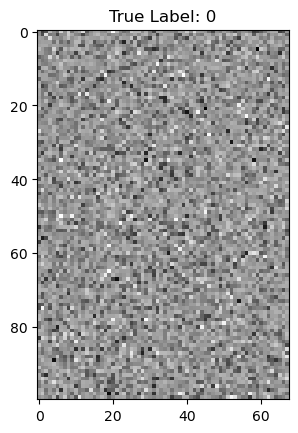

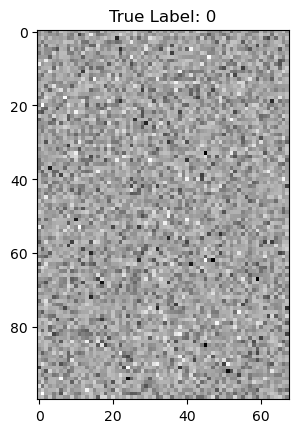

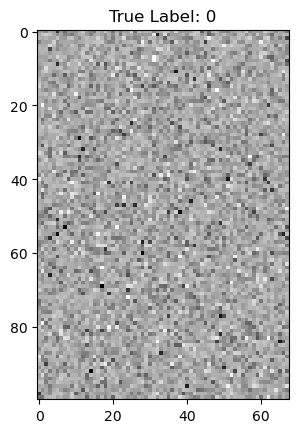

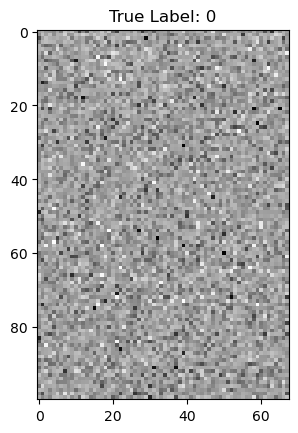

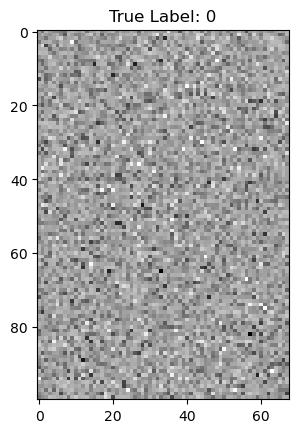

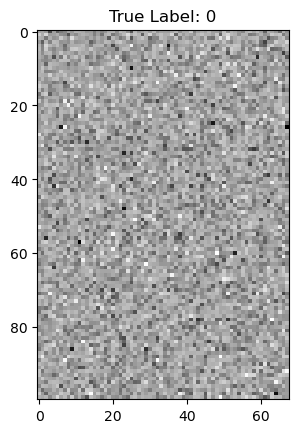

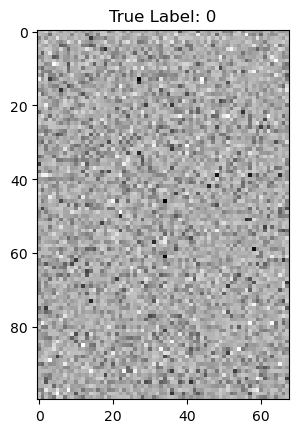

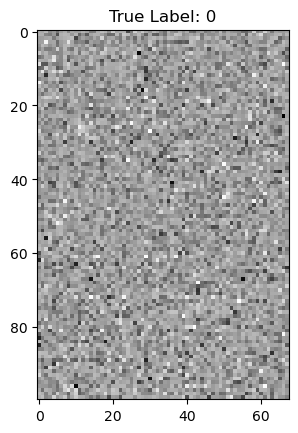

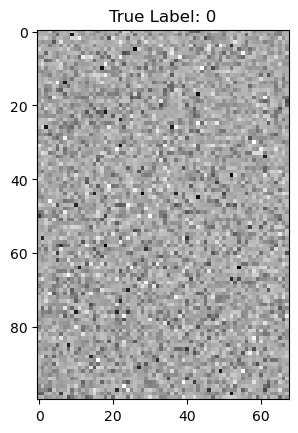

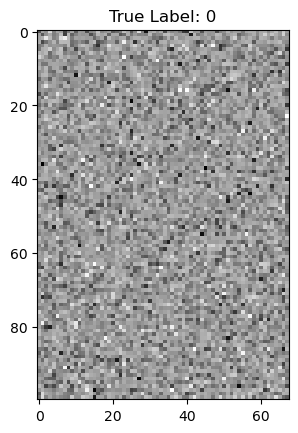

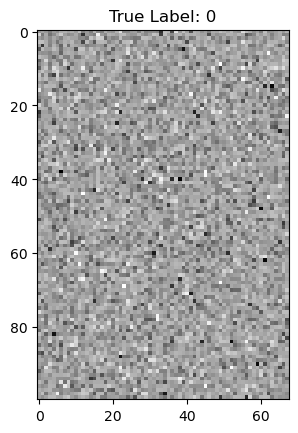

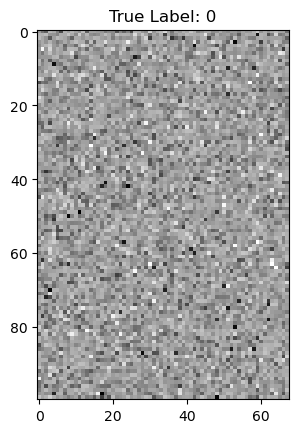

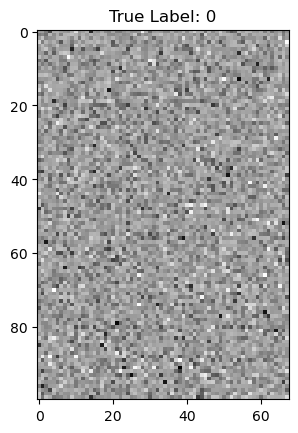

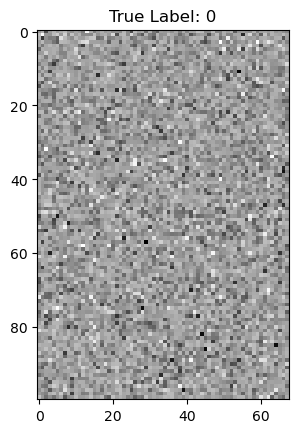

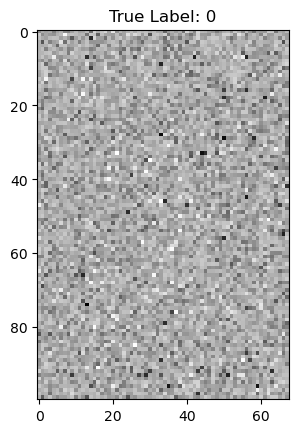

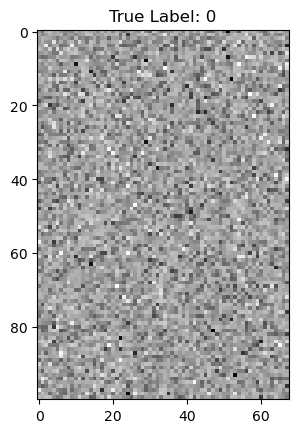

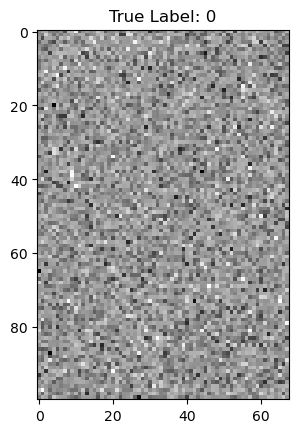

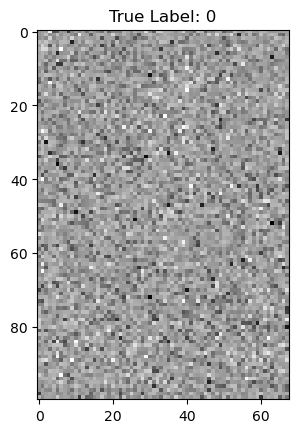

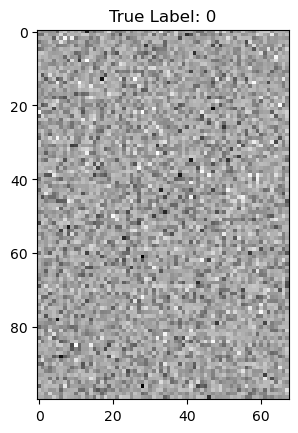

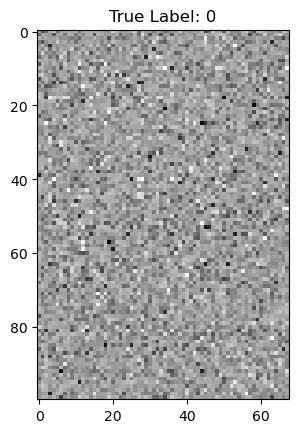

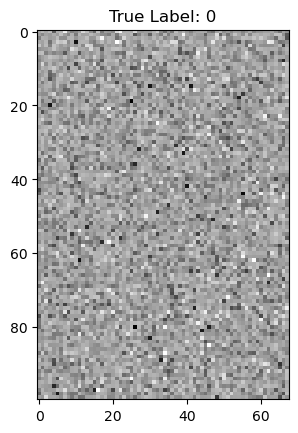

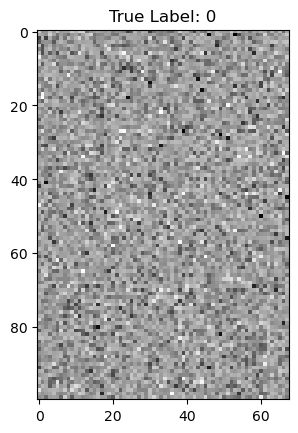

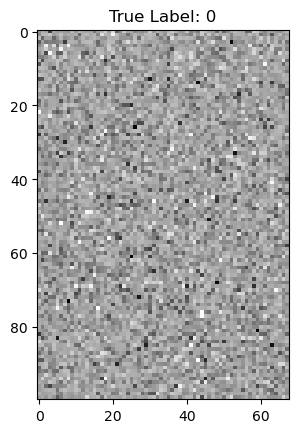

False positive rate: 0.484375


In [11]:
with torch.no_grad():
    acc = 0
    num_wrong = 0
    for _, (img_batch, label_batch) in enumerate(shuffle_dl):
        label_batch = label_batch.long()            
        label_batch = utils.one_hot(label_batch,n_classes=2)

        img_batch = img_batch.double()
        img_batch2 = utils.to_vector(img_batch)

        for i in range(len(label_batch)):
            label = label_batch[i]
            
            label_predictions = model.test_batch_supervised(img_batch2[i])

            if torch.argmax(label_predictions) != torch.argmax(label):
                num_wrong += 1
                plt.figure()
                plt.imshow(img_batch[i].squeeze(), cmap="gray")
                plt.title(f"True Label: {torch.argmax(label).item()}")
                plt.show()

sample_size = len(block_shuffle_dl.dataset)
shuffled_sample_size = sample_size // 2 #half are shuffled, half are not
print(f"False positive rate: {num_wrong/shuffled_sample_size}")

In [12]:
real_faces = load_imagenet(num_images=123, classes=["n03124170", "n09835506", "n02807133", "n04209133"])
real_faces = transform_imagenet(real_faces)
real_faces_labels = np.ones(real_faces.shape[0])
real_faces_dataset = TensorDataset(torch.from_numpy(real_faces).float().unsqueeze(1), torch.from_numpy(real_faces_labels).float())
real_faces_dl = DataLoader(real_faces_dataset, batch_size=8, shuffle=True)

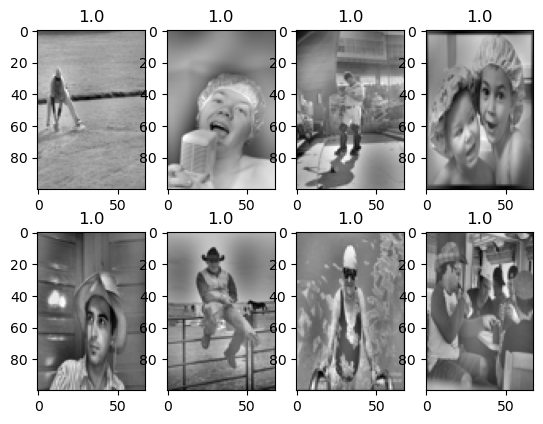

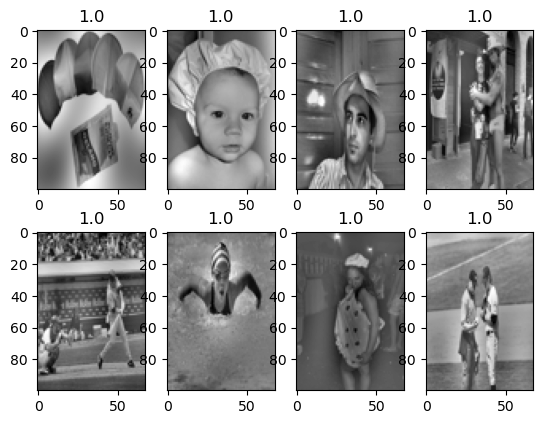

In [13]:
features, labels = next(iter(real_faces_dl))

fig, axs = plt.subplots(2, 4)
i = 0
for ax in axs.flat:
    ax.imshow(features[i].squeeze(0), cmap="gray")
    ax.set_title(labels[i].item())
    i += 1

features, labels = next(iter(real_faces_dl))

fig, axs = plt.subplots(2, 4)
i = 0
for ax in axs.flat:
    ax.imshow(features[i].squeeze(0), cmap="gray")
    ax.set_title(labels[i].item())
    i += 1

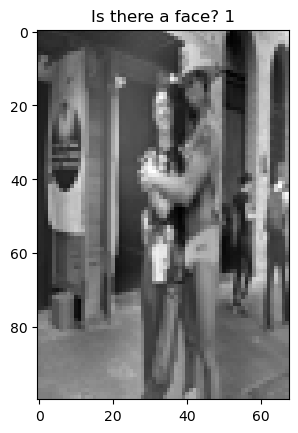

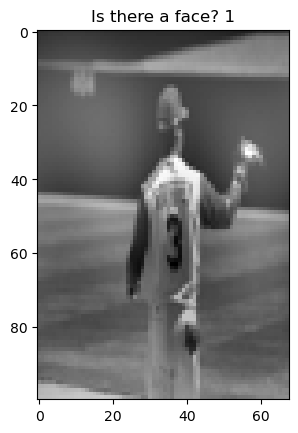

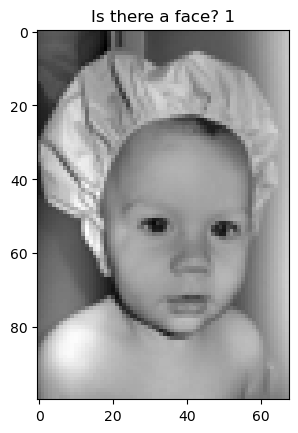

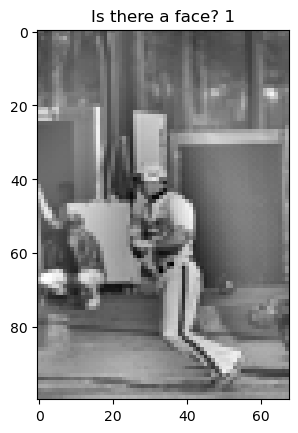

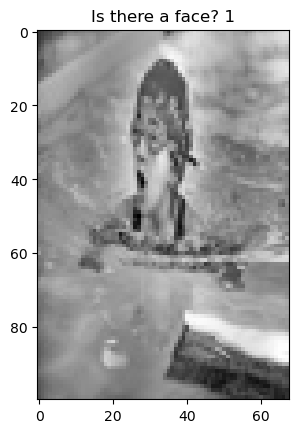

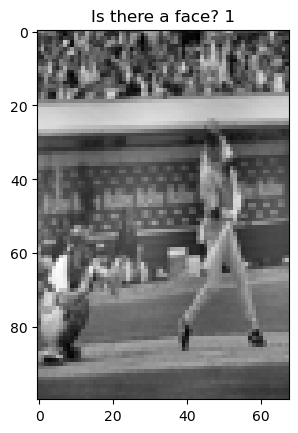

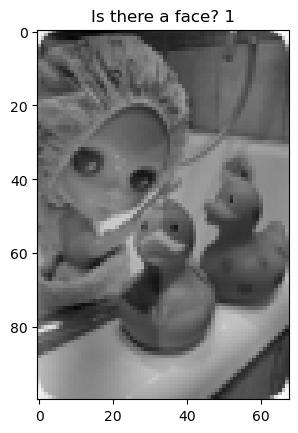

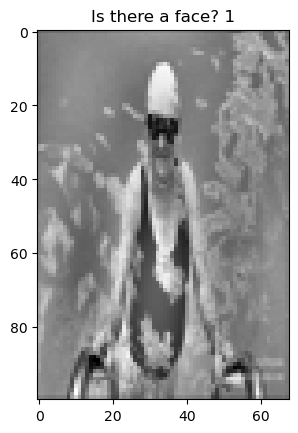

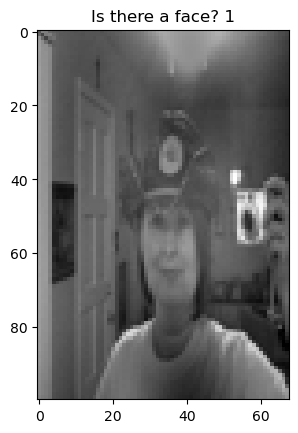

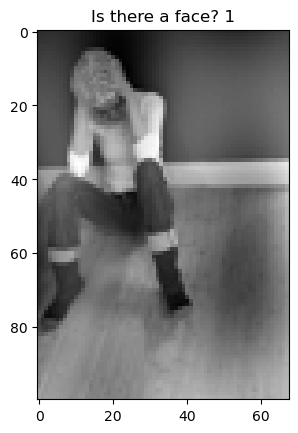

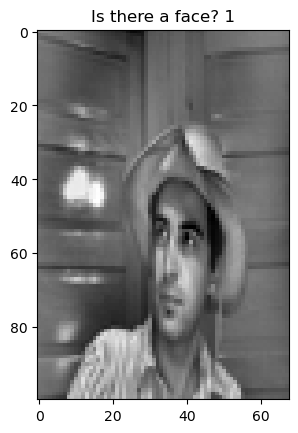

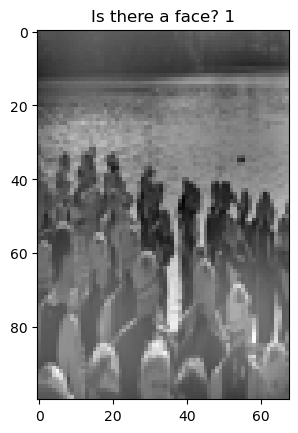

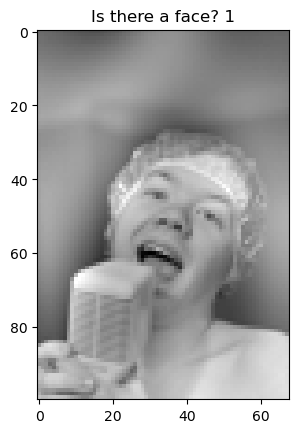

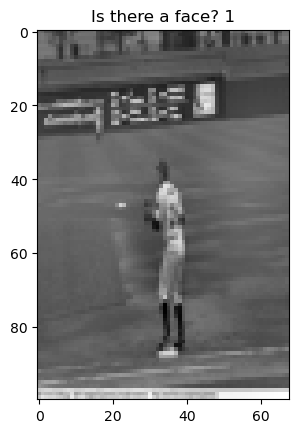

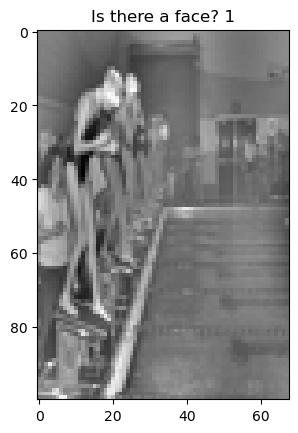

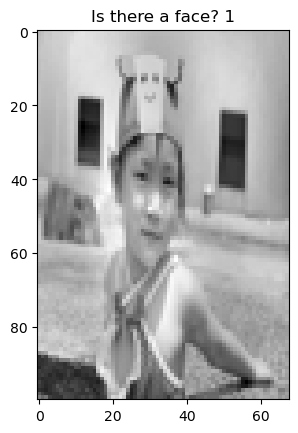

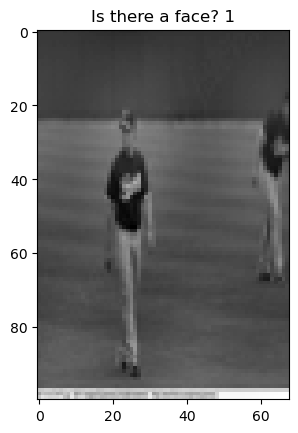

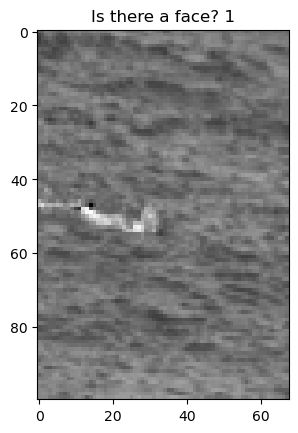

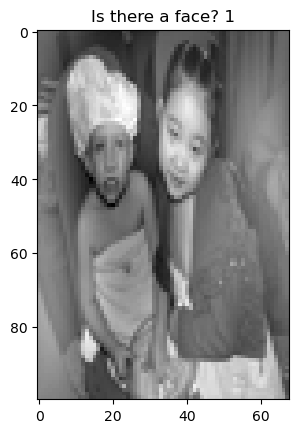

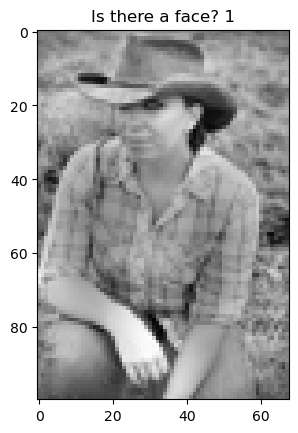

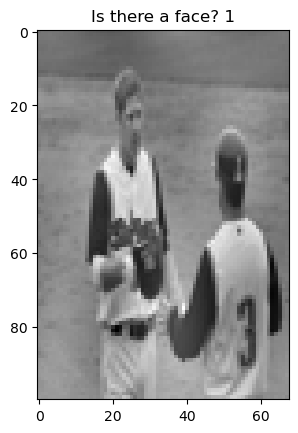

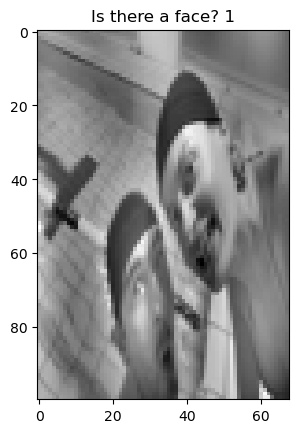

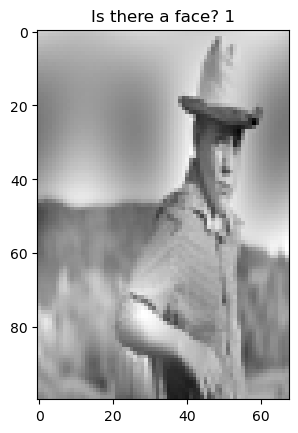

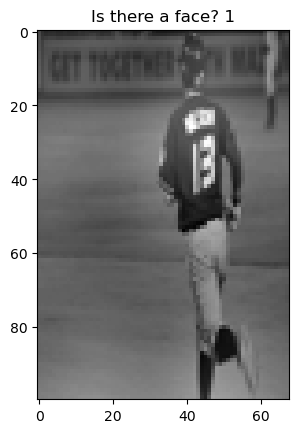

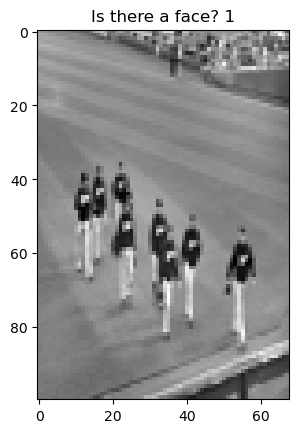

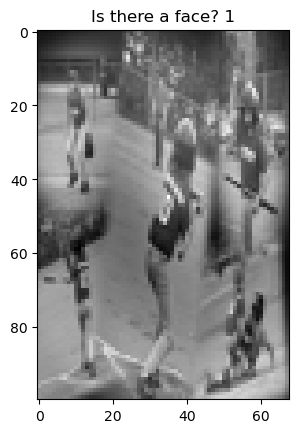

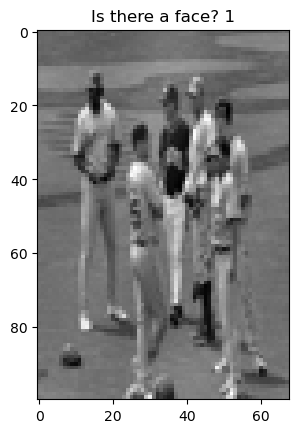

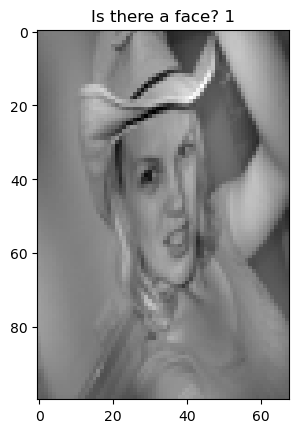

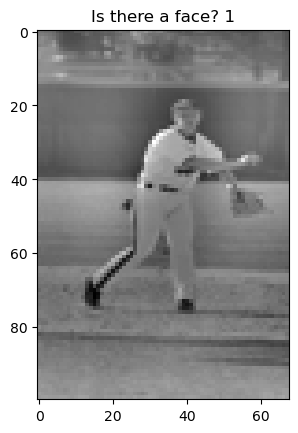

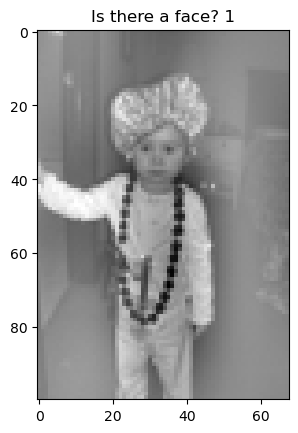

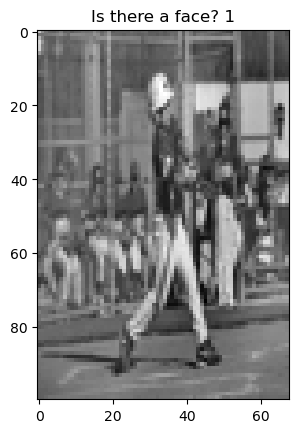

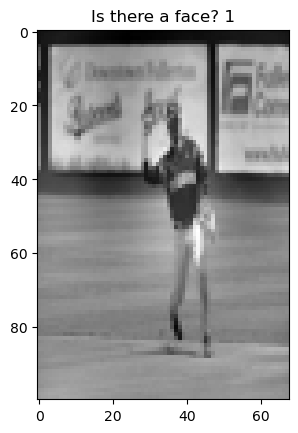

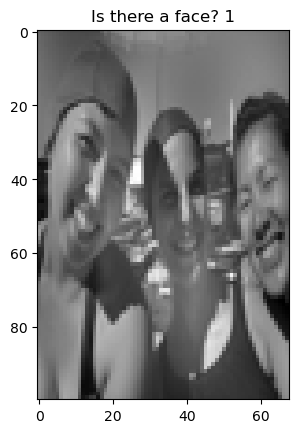

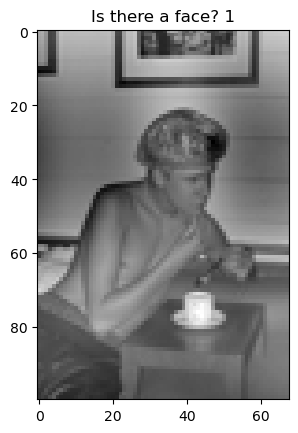

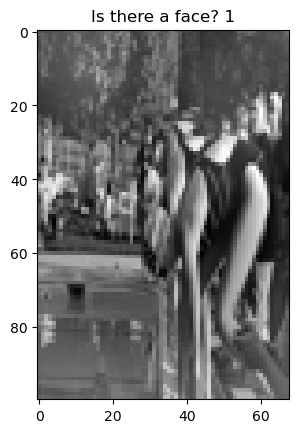

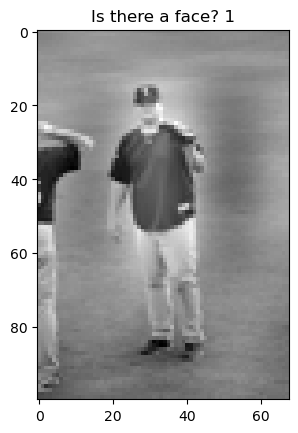

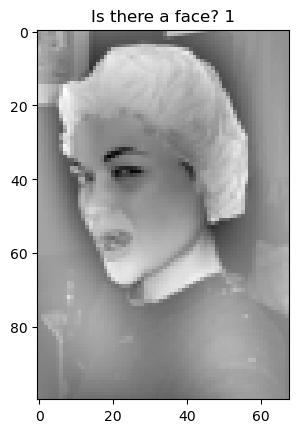

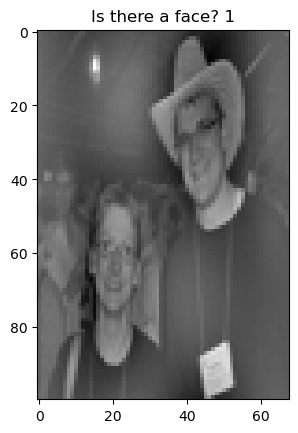

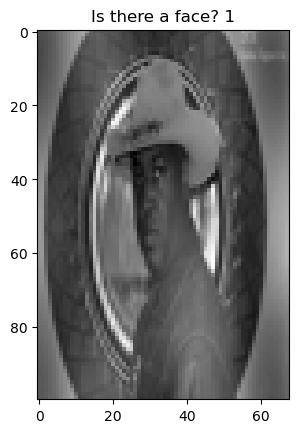

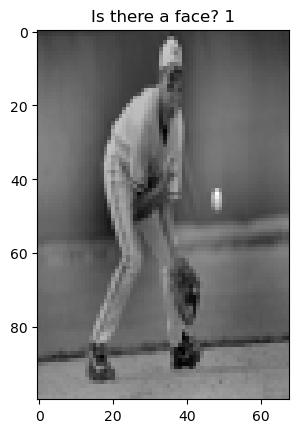

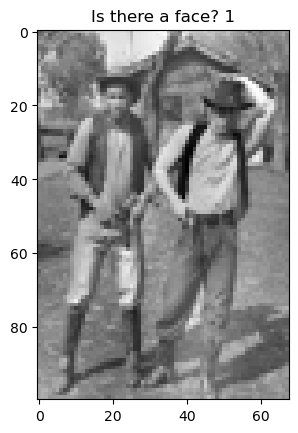

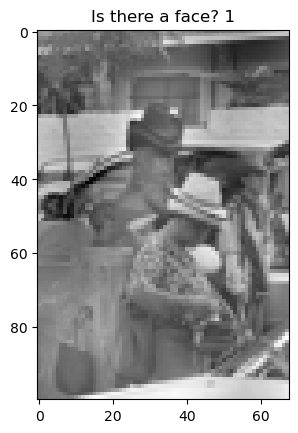

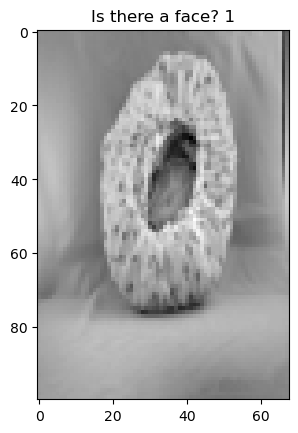

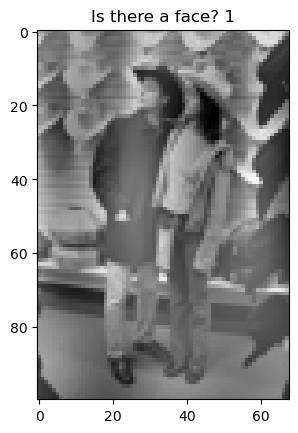

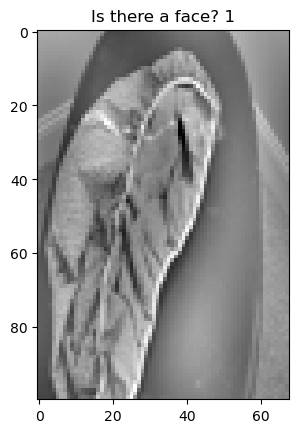

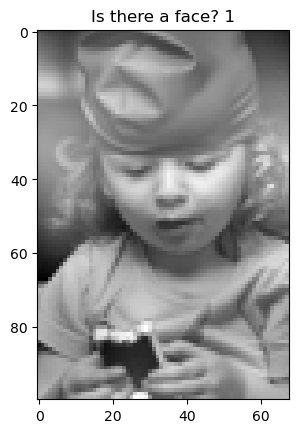

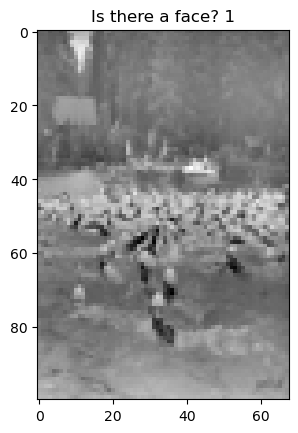

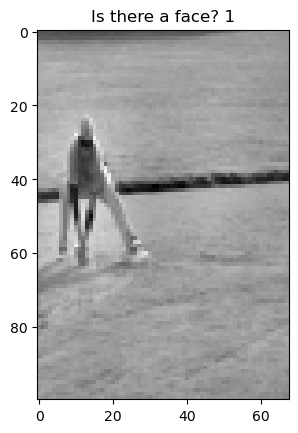

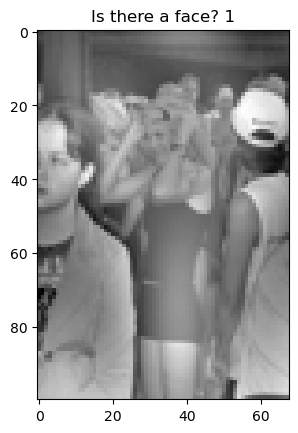

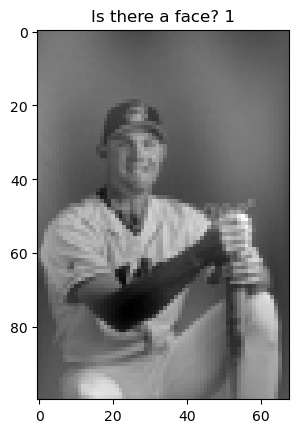

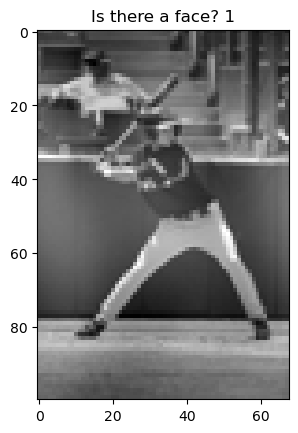

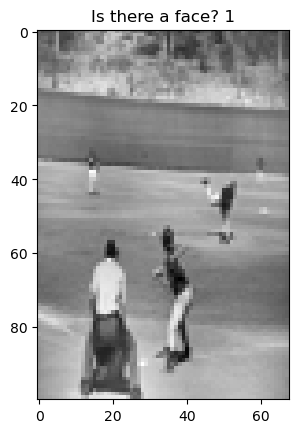

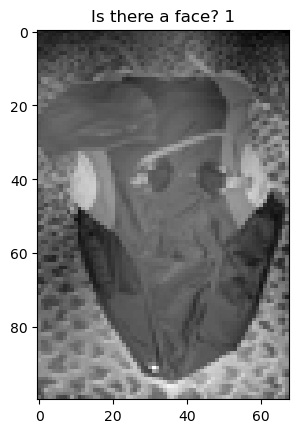

In [14]:
with torch.no_grad():
    for _, (img_batch, label_batch) in enumerate(real_faces_dl):
        label_batch = label_batch.long()            
        label_batch = utils.one_hot(label_batch,n_classes=2)

        img_batch = img_batch.double()
        img_batch2 = utils.to_vector(img_batch)

        for i in range(len(label_batch)):
            label = label_batch[i]
            
            label_predictions = model.test_batch_supervised(img_batch2[i])

            if torch.argmax(label_predictions) == 1:
                plt.figure()
                plt.imshow(img_batch[i].squeeze(), cmap="gray")
                plt.title(f"Is there a face? {torch.argmax(label_predictions).item()}")
                plt.show()

## Mnist

In [7]:
# ====================================================================================
#
# Set up Datasets and Model
#
# ====================================================================================
transform_train = transforms.Compose([
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
# When using MNIST, transform is not necessary
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform_train, download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, args.test_batch_size, shuffle=True)


D:\Anaconda\envs\myBase\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
model = PCModel(
    nodes=[28*28, 300, 100, 10],
    mu_dt=args.infer_lr,
    act_fn=utils.Tanh(),
)

optimizer = optim.get_optim(
    model.params,
    "Adam",
    args.lr,
    batch_scale=False,
    grad_clip=50,
)

In [ ]:
with torch.no_grad():
    metrics = {"acc": []}

    for epoch in range(1, args.epoch + 1):

        # Training
        print(f"Epoch {epoch} is training with ({len(train_loader)} batches)")
        for batch_id, (img_batch, label_batch) in enumerate(train_loader):
            img_batch = utils.to_vector(img_batch)
            label_batch = utils.one_hot(label_batch)

            model.train_batch_supervised(img_batch, label_batch, args.infer_iter, fixed_preds=False)

            optimizer.step(
                curr_epoch=epoch,
                curr_batch=batch_id,
                n_batches=len(train_loader),
                batch_size=img_batch.size(0),
            )

        # Testing
        if epoch % args.test_every == 0:
            acc = 0
            for _, (img_batch, label_batch) in enumerate(test_loader):
                img_batch = utils.to_vector(img_batch)
                label_batch = utils.one_hot(label_batch)

                label_preds = model.test_batch_supervised(img_batch)
                acc += utils.Want_accuracy(label_preds, label_batch)
            metrics["acc"].append(acc / len(test_loader))
            print(f"Test epoch {epoch} with Accuracy: {acc / len(test_loader)}\n")

Epoch 1 is training with (938 batches)
Test epoch 1 with Accuracy: 0.8775000000000001

Epoch 2 is training with (938 batches)
Test epoch 2 with Accuracy: 0.8949000000000001

Epoch 3 is training with (938 batches)
Test epoch 3 with Accuracy: 0.9077999999999999

Epoch 4 is training with (938 batches)
